In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate, optimize, special, interpolate
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV as cv
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

import powerlaw

In [34]:
df = pd.read_pickle('../data/df.pickle')
df.head()

,end_lat,end_lng,end_station_id,end_station_name,ended_at,member_casual,ride_id,rideable_type,start_lat,start_lng,start_station_id,start_station_name,started_at,distance,start_lat_lng,end_lat_lng
0,41.9322,-87.6586,152.0,Lincoln Ave & Diversey Pkwy,2020-04-26 18:12:03,member,A847FADBBC638E45,docked_bike,41.8964,-87.6610,86,Eckhart Park,2020-04-26 17:45:14,3.981346,"(41.8964, -87.661)","(41.9322, -87.6586)"
1,41.9306,-87.7238,499.0,Kosciuszko Park,2020-04-17 17:17:03,member,5405B80E996FF60D,docked_bike,41.9244,-87.7154,503,Drake Ave & Fullerton Ave,2020-04-17 17:08:54,0.979629,"(41.9244, -87.7154)","(41.9306, -87.7238)"
2,41.8679,-87.6230,255.0,Indiana Ave & Roosevelt Rd,2020-04-01 18:08:36,member,5DD24A79A4E006F4,docked_bike,41.8945,-87.6179,142,McClurg Ct & Erie St,2020-04-01 17:54:13,2.984661,"(41.8945, -87.6179)","(41.8679, -87.623)"
3,41.8992,-87.6722,657.0,Wood St & Augusta Blvd,2020-04-07 13:02:31,member,2A59BBDF5CDBA725,docked_bike,41.9030,-87.6975,216,California Ave & Division St,2020-04-07 12:50:19,2.141375,"(41.903, -87.6975)","(41.8992, -87.6722)"
4,41.9695,-87.6547,323.0,Sheridan Rd & Lawrence Ave,2020-04-18 11:15:54,casual,27AD306C119C6158,docked_bike,41.8902,-87.6262,125,Rush St & Hubbard St,2020-04-18 10:22:59,9.119685,"(41.8902, -87.6262)","(41.9695, -87.6547)"


In [35]:
df_lockdown = df[(df["started_at"] >= "2020-03-21") & (df["started_at"] < "2020-06-01")].dropna()
df_20200601_20201116 = df[(df["started_at"] >= "2020-06-01") & (df["started_at"] < "2020-11-17")].dropna()
df_20201117_20201216 = df[(df["started_at"] >= "2020-11-17") & (df["started_at"] < "2020-12-17")].dropna()
df_20201217_20201231 = df[(df["started_at"] >= "2020-12-17") & (df["started_at"] < "2021-01-01")].dropna()
df_2021 = df[(df["started_at"] >= "2021-01-01") & (df["started_at"] < "2022-01-01")].dropna()
df_2022 = df[(df["started_at"] >= "2022-01-01") & (df["started_at"] < "2023-01-01")].dropna()
df_2023 = df[(df["started_at"] >= "2023-01-01") & (df["started_at"] < "2023-10-01")].dropna()
df_2020 = df[(df["started_at"] >= "2020-01-01") & (df["started_at"] < "2021-01-01")].dropna()

True

In [36]:
def getNetworkAnalysis(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    df = df.sort_values(by='start_station_name')

    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []
    distance_list = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # ユニークな駅のリストを取得
        # values.ravel('K')で多次元配列を1次元配列に変換
        unique_stations = pd.unique(df_tmp[['start_station_name', 'end_station_name']].values.ravel('K'))

        # node_listにノード数を追加
        node_list.append(len(unique_stations))

        # edge_listにエッジ数を追加
        df_tmp = df_tmp.drop_duplicates(subset=['start_station_name', 'end_station_name'])
        edge_list.append(len(df_tmp))

        # distance_listに平均距離を追加
        distance_list.append(df_tmp['distance'].mean())

        current_timestamp = next_timestamp

    return node_list, edge_list, timestamp

In [37]:
node_2020, edge_2020, timestamp_2020 = getNetworkAnalysis(df_2020)
node_20200601_20201116, edge_20200601_20201116, timestamp_20200601_20201116 = getNetworkAnalysis(df_20200601_20201116)
node_20201117_20201216, edge_20201117_20201216, timestamp_20201117_20201216 = getNetworkAnalysis(df_20201117_20201216)
node_20201217_20201231, edge_20201217_20201231, timestamp_20201217_20201231 = getNetworkAnalysis(df_20201217_20201231)
node_2021, edge_2021, timestamp_2021 = getNetworkAnalysis(df_2021)
node_2022, edge_2022, timestamp_2022 = getNetworkAnalysis(df_2022)
node_2023, edge_2023, timestamp_2023 = getNetworkAnalysis(df_2023)

In [7]:
# 2020のnodeとedgeの推移

plt.figure(figsize=(14, 7))

# node_2020とedge_2020の組み合わせで、0が入っているものを削除


N = node_2020
M = edge_2020

res = smf.ols(formula="np.log(M)~np.log(N)", data=pd.DataFrame({"N":N, "M":M})).fit()
x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.scatter(N, M, marker='x', color="g", label='Year: 2020', alpha=0.8)


plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")

plt.tick_params(labelsize=20)
plt.legend(prop={'size': 30})
plt.show()

LinAlgError: SVD did not converge

<Figure size 1400x700 with 0 Axes>

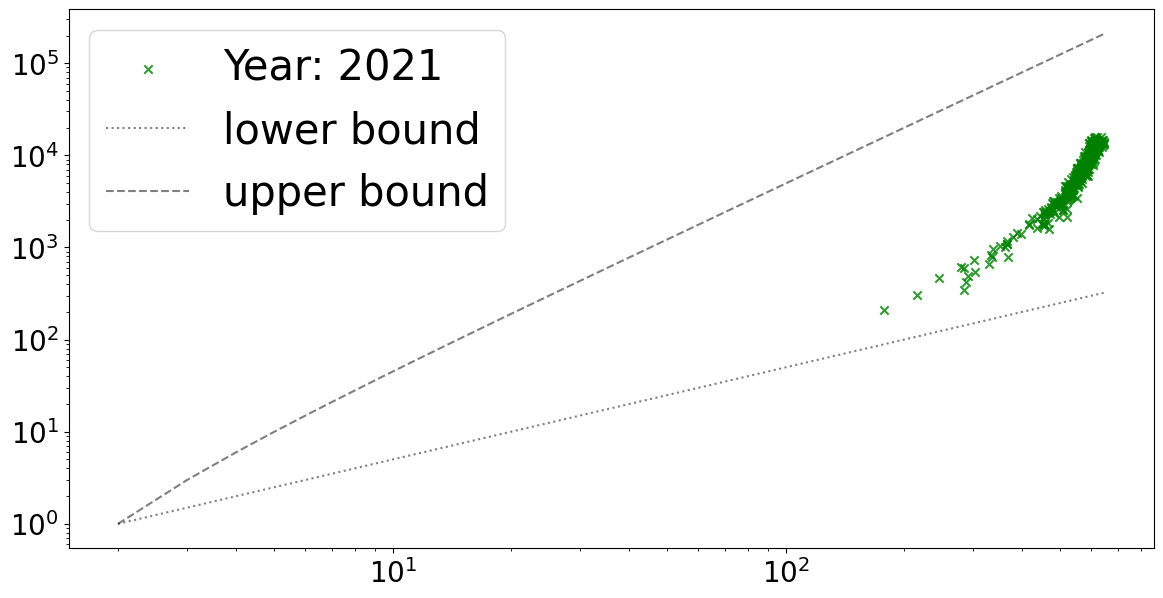

In [ ]:
# 2020のnodeとedgeの推移

plt.figure(figsize=(14, 7))

# node_2020とedge_2020の組み合わせで、0が入っているものを削除


N = node_2021
M = edge_2021

res = smf.ols(formula="np.log(M)~np.log(N)", data=pd.DataFrame({"N":N, "M":M})).fit()
x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.scatter(N, M, marker='x', color="g", label='Year: 2021', alpha=0.8)


plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")

plt.tick_params(labelsize=20)
plt.legend(prop={'size': 30})
plt.show()

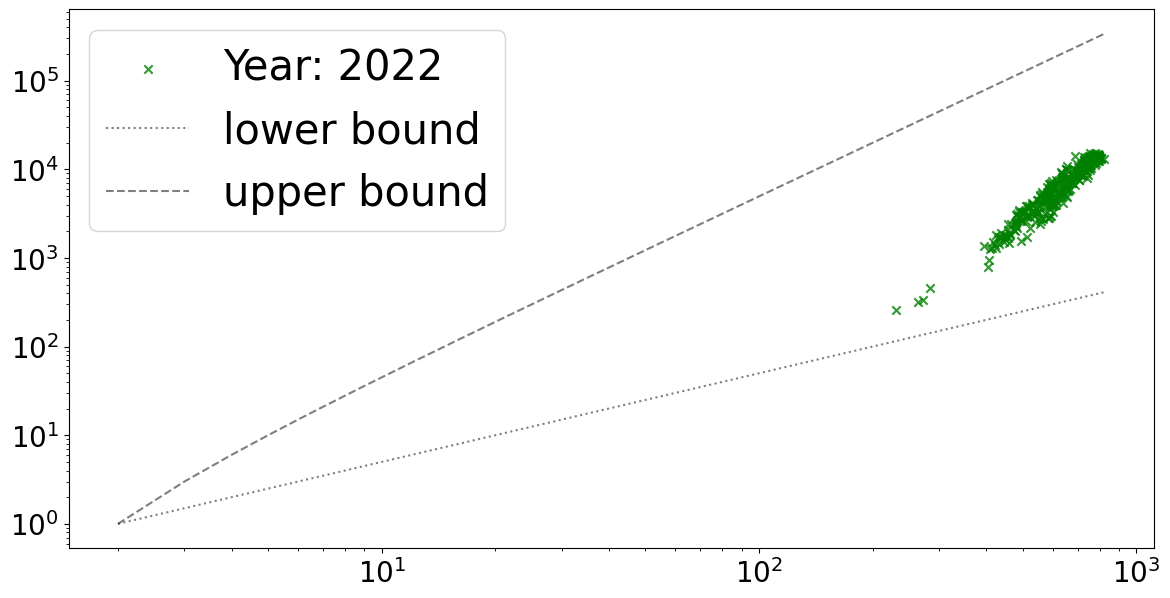

In [ ]:
# 2020のnodeとedgeの推移

plt.figure(figsize=(14, 7))

# node_2020とedge_2020の組み合わせで、0が入っているものを削除


N = node_2022
M = edge_2022

res = smf.ols(formula="np.log(M)~np.log(N)", data=pd.DataFrame({"N":N, "M":M})).fit()
x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.scatter(N, M, marker='x', color="g", label='Year: 2022', alpha=0.8)


plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")

plt.tick_params(labelsize=20)
plt.legend(prop={'size': 30})
plt.show()

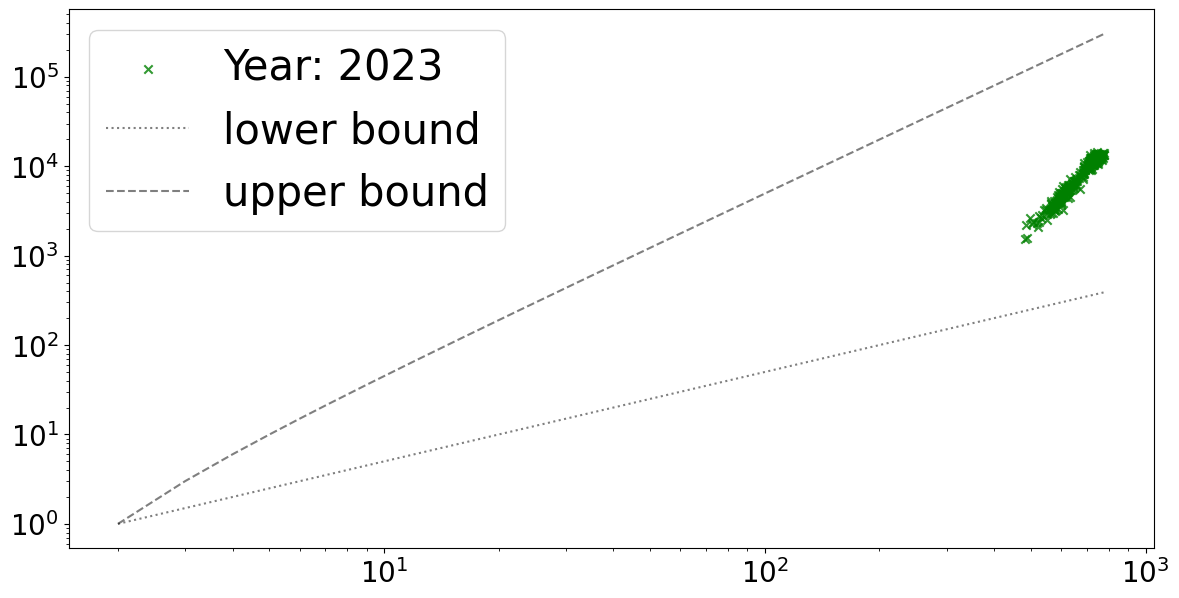

In [ ]:
# 2020のnodeとedgeの推移

plt.figure(figsize=(14, 7))

# node_2020とedge_2020の組み合わせで、0が入っているものを削除


N = node_2023
M = edge_2023

res = smf.ols(formula="np.log(M)~np.log(N)", data=pd.DataFrame({"N":N, "M":M})).fit()
x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))
plt.scatter(N, M, marker='x', color="g", label='Year: 2023', alpha=0.8)


plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")

plt.xscale("log")
plt.yscale("log")

plt.tick_params(labelsize=20)
plt.legend(prop={'size': 30})
plt.show()

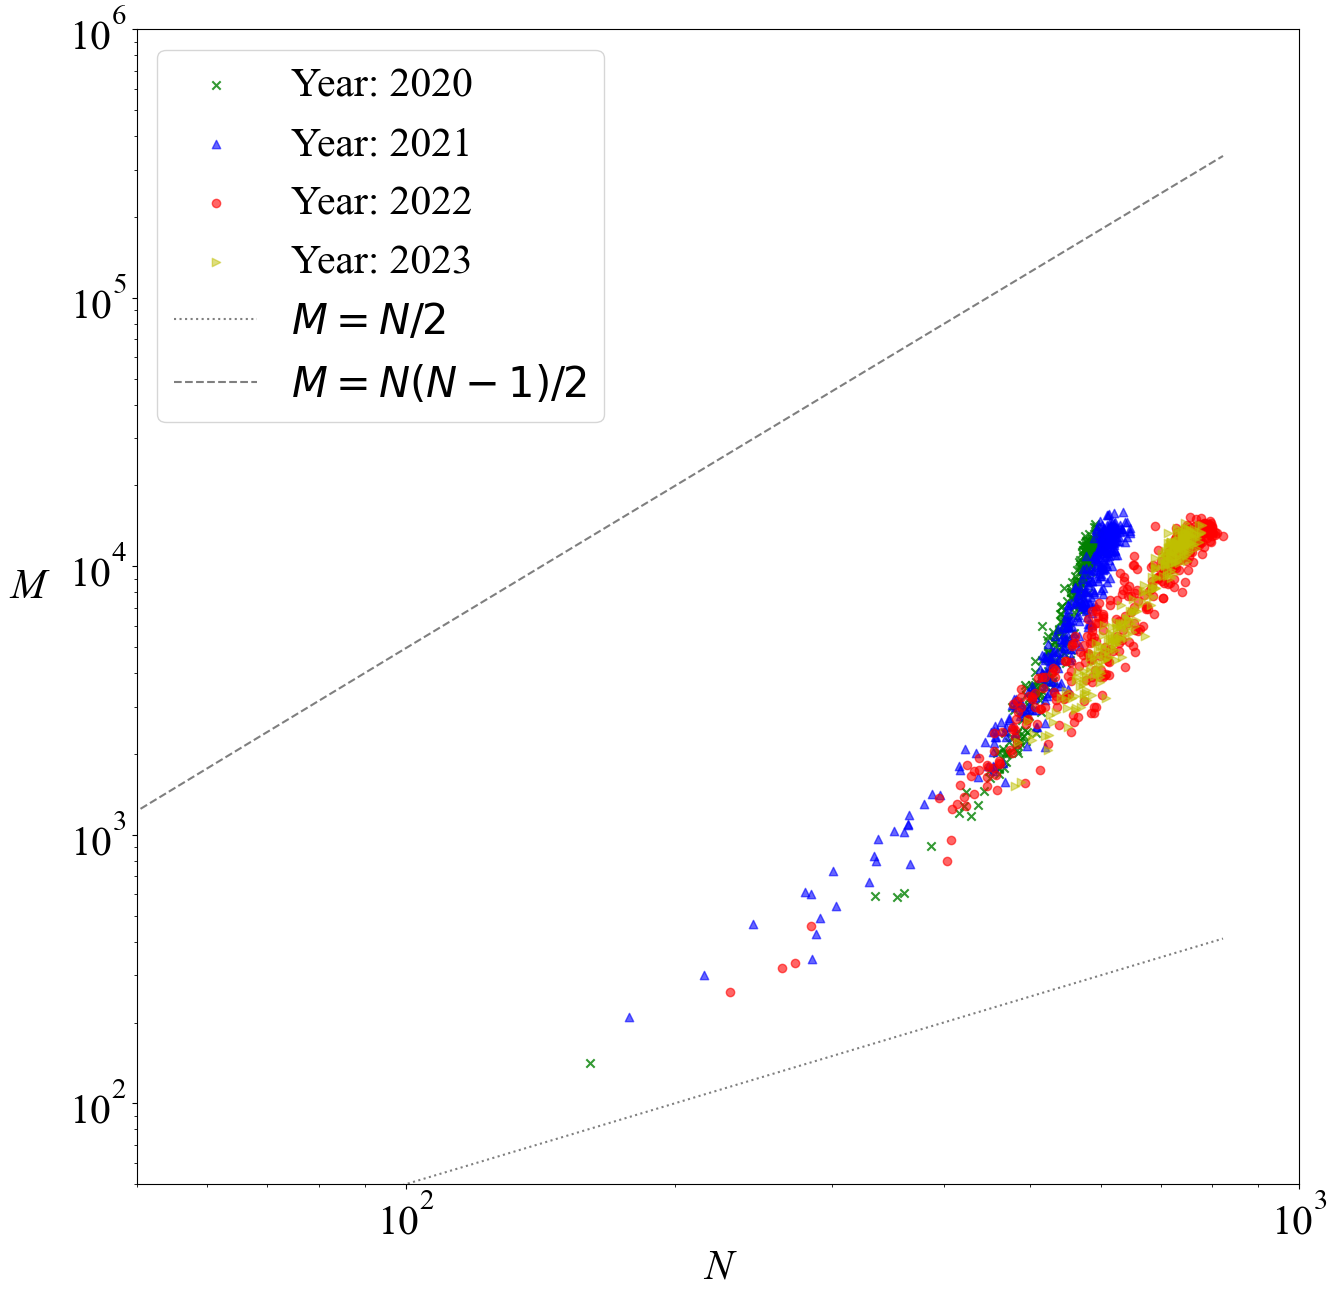

In [43]:
N = []
M = []

N.extend(node_2020)
N.extend(node_2021)
N.extend(node_2022)
N.extend(node_2023)

M.extend(edge_2020)
M.extend(edge_2021)
M.extend(edge_2022)
M.extend(edge_2023)

x = np.arange(2, np.max(N))
y = np.arange(200, np.max(M))

plt.figure(figsize=(15, 15))

plt.rcParams["font.size"] = 30
plt.rcParams['font.family'] = 'Times New Roman'

plt.scatter(node_2020, edge_2020, marker='x', color="g", label='Year: 2020', alpha=0.8)
plt.scatter(node_2021, edge_2021, marker='^', color="b", label='Year: 2021', alpha=0.6)
plt.scatter(node_2022, edge_2022, marker='o', color="r", label='Year: 2022', alpha=0.6)
plt.scatter(node_2023, edge_2023, marker='>', color="y", label='Year: 2023', alpha=0.5)

plt.plot(x,x/2, label=f"$M = N / 2$", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label=f"$M = N(N-1)/2$", c = "black", alpha = 0.5, ls = "--")

plt.xlim(50, 1000)
plt.ylim(50, 1000000)

plt.xscale("log")
plt.yscale("log")
plt.tick_params(labelsize=30)
plt.legend(prop={'size': 30})
# 各ラベルはイタリック
plt.xlabel("N", fontsize=30, style="italic")
plt.ylabel("M", fontsize=30, rotation=0, style="italic", labelpad=30)


# pdf形式で保存
plt.savefig("../fig/cssj/scale_all.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show()

In [6]:
node_lockdown, edge_lockdown, timestamp_lockdown, distance_lockdown = getNetworkAnalysis(df_lockdown)
node_after_lockdown, edge_after_lockdown, timestamp_after_lockdown, distance_after_lockdown = getNetworkAnalysis(df_20200601_20201116)
node_stayhome, edge_stayhome, timestamp_stayhome, distance_stayhome = getNetworkAnalysis(df_20201117_20201216)
node_after_stayhome, edge_after_stayhome, timestamp_after_stayhome, distance_after_stayhome = getNetworkAnalysis(df_20201217_20201231)
node_2020, edge_2020, timestamp_2020, distance_2020 = getNetworkAnalysis(df_2020)
node_2021, edge_2021, timestamp_2021, distance_2021 = getNetworkAnalysis(df_2021)
node_2022, edge_2022, timestamp_2022, distance_2022 = getNetworkAnalysis(df_2022)
node_2023, edge_2023, timestamp_2023, distance_2023 = getNetworkAnalysis(df_2023)

In [44]:
# nodeの中の最小値
print("node_lockdown:", min(node_lockdown))
print("node_after_lockdown:", min(node_after_lockdown))
print("node_stayhome:", min(node_stayhome))
print("node_after_stayhome:", min(node_after_stayhome))
print("node_2020:", min(node_2020))
print("node_2021:", min(node_2021))
print("node_2022:", min(node_2022))
print("node_2023:", min(node_2023))

node_lockdown: 161
node_after_lockdown: 472
node_stayhome: 461
node_after_stayhome: 355
node_2020: 0
node_2021: 178
node_2022: 231
node_2023: 481


In [45]:
# nodeの中の最大値  
print("node_lockdown:", max(node_lockdown))
print("node_after_lockdown:", max(node_after_lockdown))
print("node_stayhome:", max(node_stayhome))
print("node_after_stayhome:", max(node_after_stayhome))
print("node_2020:", max(node_2020))
print("node_2021:", max(node_2021))
print("node_2022:", max(node_2022))
print("node_2023:", max(node_2023))


node_lockdown: 569
node_after_lockdown: 601
node_stayhome: 542
node_after_stayhome: 515
node_2020: 602
node_2021: 647
node_2022: 823
node_2023: 779


In [46]:
# edgeの中の最小値
print("edge_lockdown:", min(edge_lockdown))
print("edge_after_lockdown:", min(edge_after_lockdown))
print("edge_stayhome:", min(edge_stayhome))
print("edge_after_stayhome:", min(edge_after_stayhome))
print("edge_2020:", min(edge_2020))
print("edge_2021:", min(edge_2021))
print("edge_2022:", min(edge_2022))
print("edge_2023:", min(edge_2023))

edge_lockdown: 142
edge_after_lockdown: 2302
edge_stayhome: 1774
edge_after_stayhome: 585
edge_2020: 0
edge_2021: 209
edge_2022: 259
edge_2023: 1516


In [47]:
# edgeの中の最大値
print("edge_lockdown:", max(edge_lockdown))
print("edge_after_lockdown:", max(edge_after_lockdown))
print("edge_stayhome:", max(edge_stayhome))
print("edge_after_stayhome:", max(edge_after_stayhome))
print("edge_2020:", max(edge_2020))
print("edge_2021:", max(edge_2021))
print("edge_2022:", max(edge_2022))
print("edge_2023:", max(edge_2023))

edge_lockdown: 10197
edge_after_lockdown: 14441
edge_stayhome: 6627
edge_after_stayhome: 3711
edge_2020: 14393
edge_2021: 15961
edge_2022: 15218
edge_2023: 14446


In [8]:
alpha_lockdown, beta_lockdown = 0.086, 1.257
alpha_after_lockdown, beta_after_lockdown = 0.085, 5.735
alpha_stayhome, beta_stayhome = 0.085, 1.626
alpha_after_stayhome, beta_after_stayhome = 0.094, 3.621
alpha_2020, beta_2020 = 0.075, 0.795 
alpha_2021, beta_2021 = 0.087, 2.238
alpha_2022, beta_2022 = 0.118, 8.603
alpha_2023, beta_2023 = 0.119, 7.9

Np = 1652

In [7]:
def Model3(M):

    def obj(a,i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)

    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i), limit=5000)[0]

    N = Np*(1 - vals)
    return N

def kappa(M, Np):
    return ((alpha+beta)/alpha)**2*2*M/Np/(Np-1)

def Model3_fixed(M, alpha, beta):
    def obj(a, i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)
    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
    
    N = Np*(1 - vals)
    return N 

In [8]:
kappa_lockdown = []
for i in range(len(edge_lockdown)):
    alpha, beta = alpha_lockdown, beta_lockdown
    kappa_lockdown.append(kappa(edge_lockdown[i], Np))

NameError: name 'alpha_lockdown' is not defined

In [ ]:
kappa_after_lockdown = []
for i in range(len(edge_after_lockdown)):
    alpha, beta = alpha_after_lockdown, beta_after_lockdown
    # NAになる場合は処理をスキップ
    if edge_after_lockdown[i] == 0:
        pass
    kappa_after_lockdown.append(kappa(edge_after_lockdown[i], Np))

In [ ]:
kappa_stayhome = []
for i in range(len(edge_stayhome)):
    alpha, beta = alpha_stayhome, beta_stayhome
    kappa_stayhome.append(kappa(edge_stayhome[i], Np))

In [ ]:
kappa_after_stayhome = []
for i in range(len(edge_after_stayhome)):
    alpha, beta = alpha_after_stayhome, beta_after_stayhome
    kappa_after_stayhome.append(kappa(edge_after_stayhome[i], Np))

In [ ]:
kappa_2020 = []
for i in range(len(edge_2020)):
    alpha, beta = alpha_2020, beta_2020
    kappa_2020.append(kappa(edge_2020[i], Np=Np))

In [ ]:
kappa_2021 = []
for i in range(len(edge_2021)):
    alpha, beta = alpha_2021, beta_2021
    kappa_2021.append(kappa(edge_2021[i],Np=Np))

In [ ]:
kappa_2022 = []
for i in range(len(edge_2022)):
    alpha, beta = alpha_2022, beta_2022
    kappa_2022.append(kappa(edge_2022[i],Np=Np))

In [ ]:
kappa_2023 = []
for i in range(len(edge_2023)):
    alpha, beta = alpha_2023, beta_2023
    kappa_2023.append(kappa(edge_2023[i],Np=Np))

In [ ]:
kappa_distance_2020_df = pd.DataFrame({"kappa": kappa_2020, "distance": distance_2020})

In [ ]:
# kappa_distance_2020_dfのnaを削除
kappa_distance_2020_df = kappa_distance_2020_df.dropna()

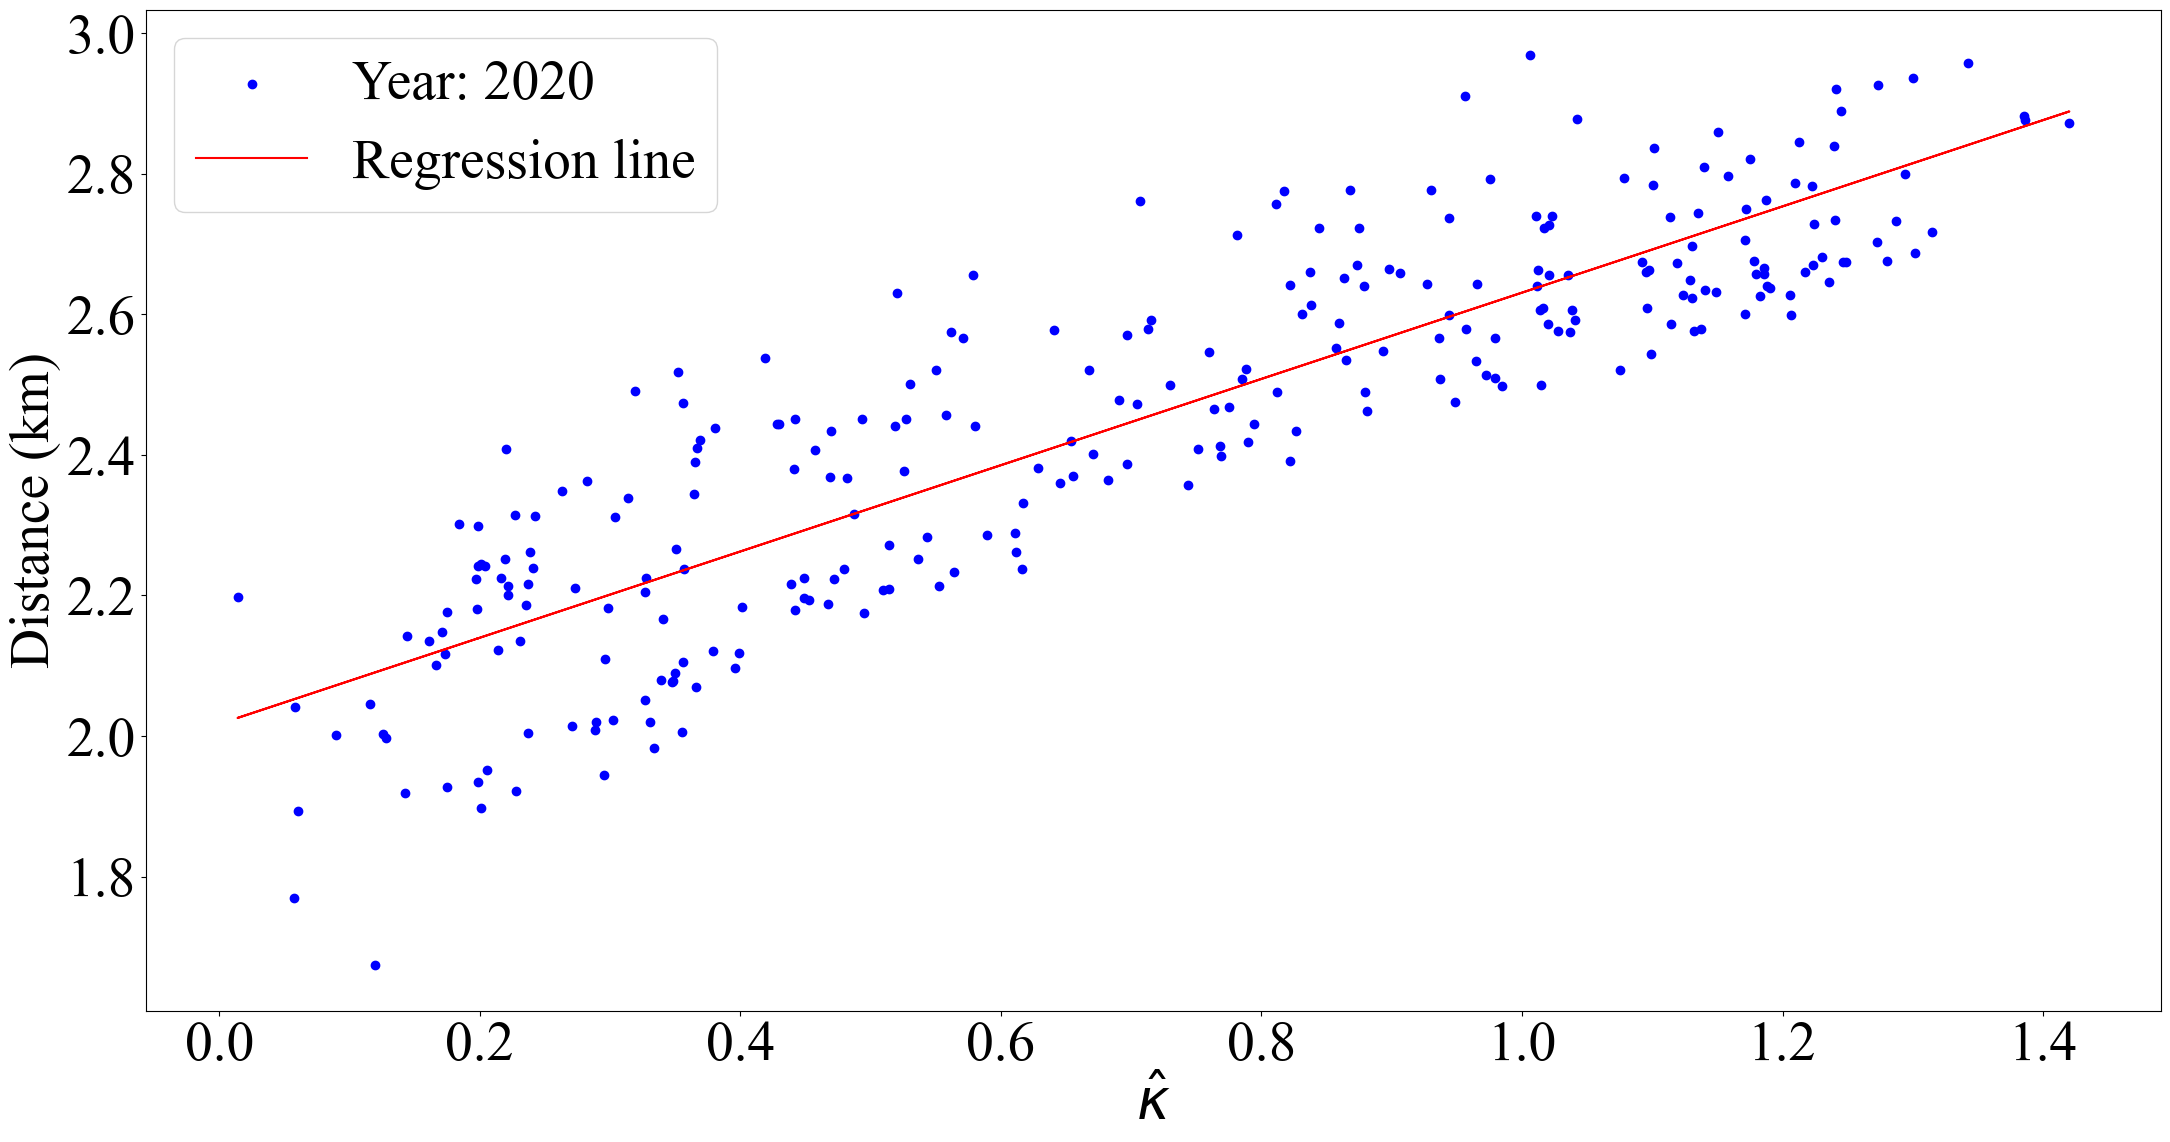

In [29]:
# 2022年のkappaと距離の関係
# モデルの当てはめ

model = smf.ols("distance ~ kappa", data=kappa_distance_2020_df)
result = model.fit()

plt.figure(figsize=(26, 13))
plt.rcParams["font.size"] = 30
plt.rcParams["font.family"] = "Times New Roman"

plt.scatter(kappa_distance_2020_df["kappa"], kappa_distance_2020_df["distance"], label="Year: 2020", color="blue")
plt.plot(kappa_distance_2020_df["kappa"], result.fittedvalues, color="red", label="Regression line")
# plt.text(0.2, 0.1, f"y = {result.params[1]:.3f} + {result.params[0]:.3f}", transform=plt.gca().transAxes, fontsize=30)

plt.xlabel(r"$\hat{\kappa}$", fontsize=40)
plt.ylabel("Distance (km)", fontsize=40)
plt.tick_params(labelsize=40)
plt.legend(prop={"size": 40})
plt.savefig("../fig/cssj/kappa_distance_2020.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show()

In [33]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     882.6
Date:                Sun, 11 Feb 2024   Prob (F-statistic):           3.17e-87
Time:                        23:50:25   Log-Likelihood:                 175.75
No. Observations:                 273   AIC:                            -347.5
Df Residuals:                     271   BIC:                            -340.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0172      0.016    122.351      0.0

In [ ]:
kappa_distance_2022_df = pd.DataFrame({"kappa": kappa_2022, "distance": distance_2022})
kappa_distance_2022_df = kappa_distance_2022_df[kappa_distance_2022_df["distance"] < 10]

kappa_distance_2023_df = pd.DataFrame({"kappa": kappa_2023, "distance": distance_2023}) 
kappa_distance_2023_df = kappa_distance_2023_df[kappa_distance_2023_df["distance"] < 3]

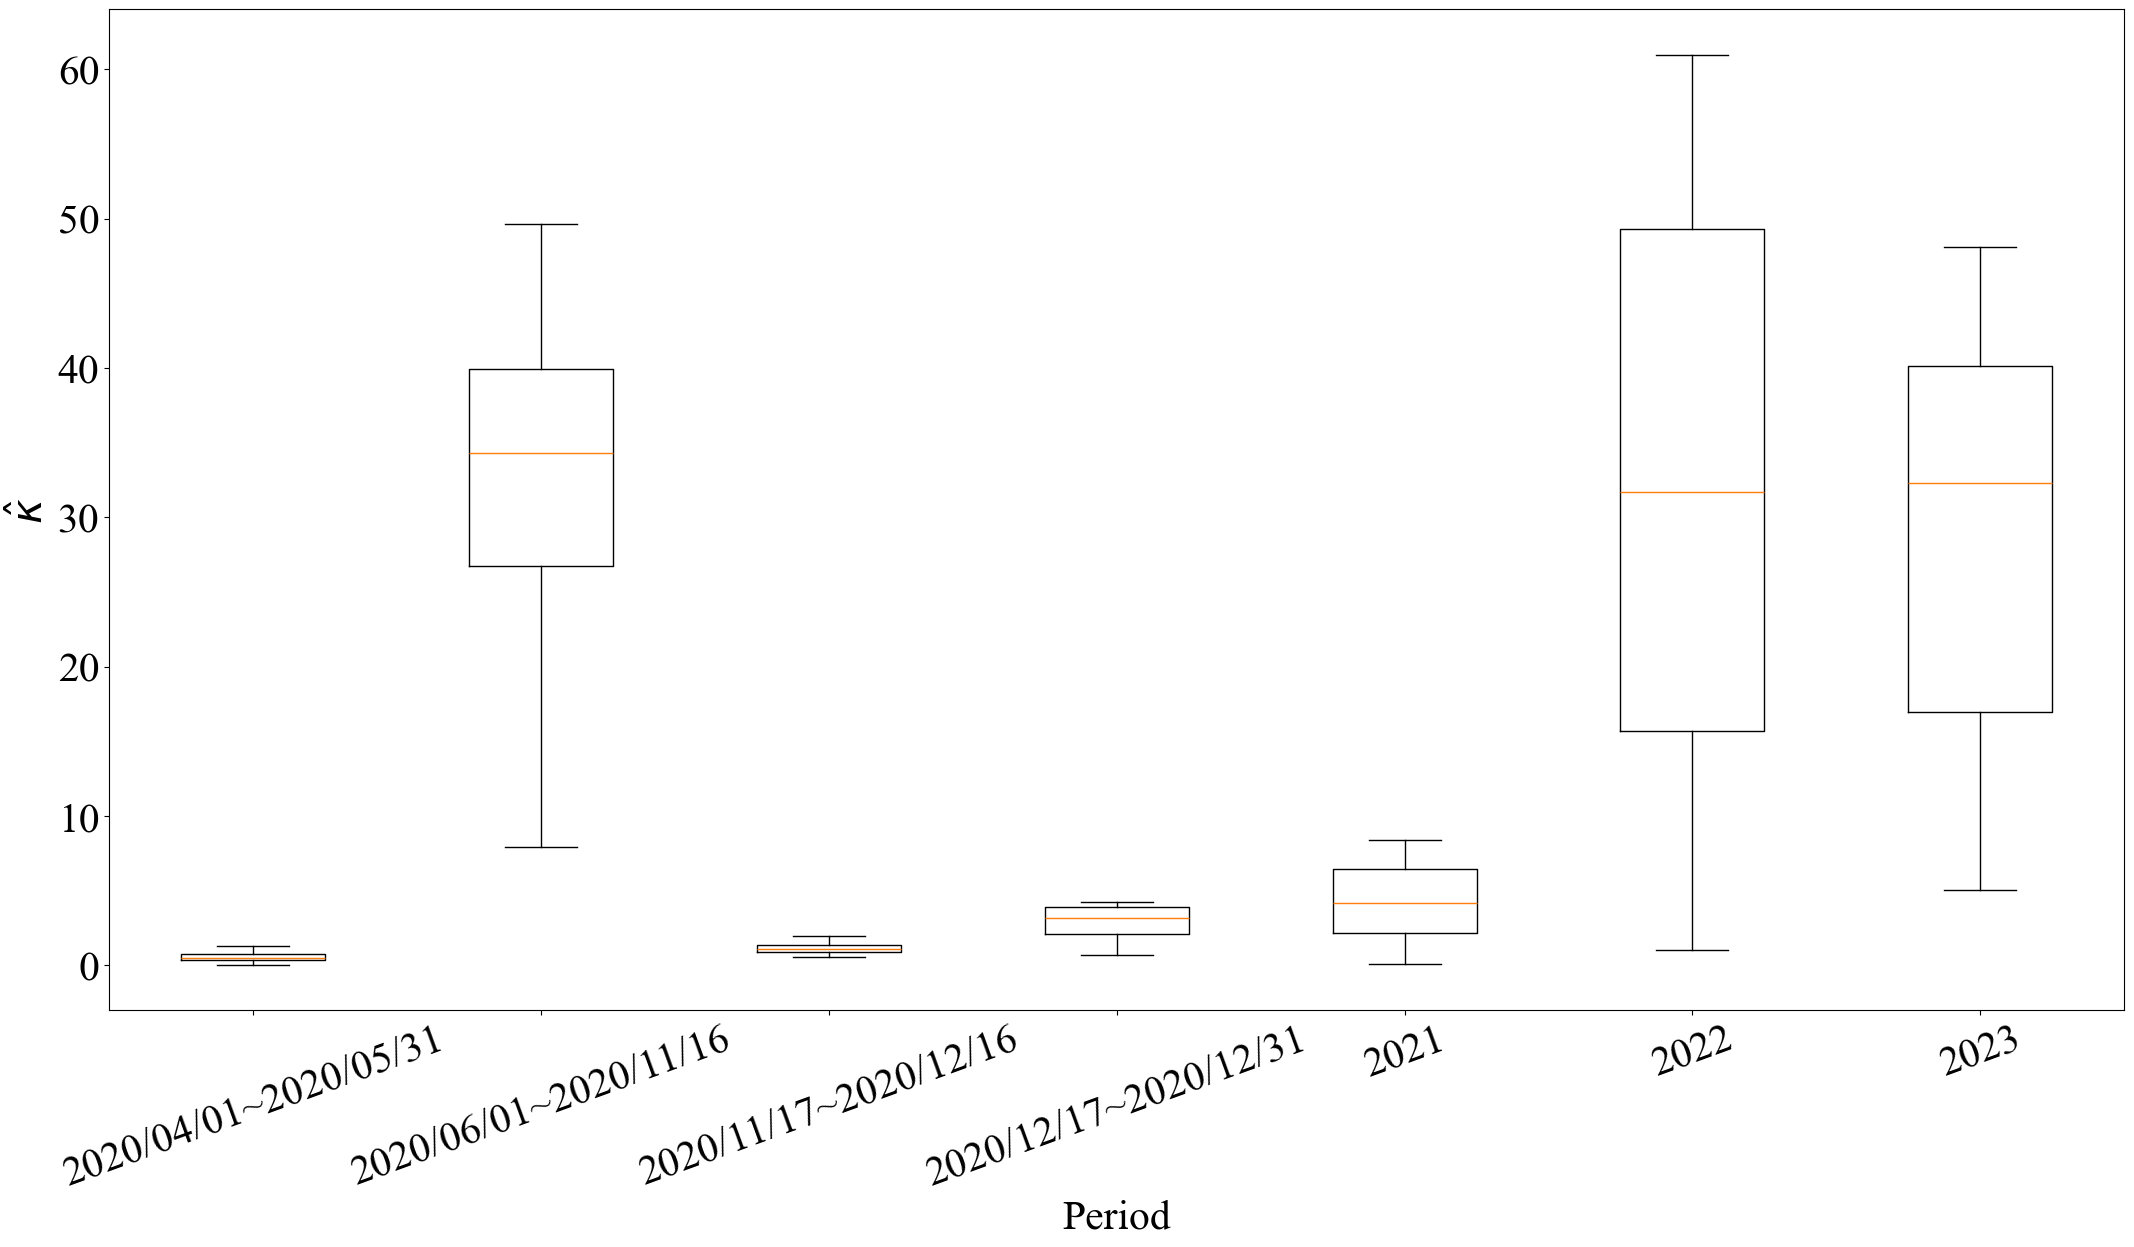

In [32]:
# box plot
plt.figure(figsize=(26,13))
plt.rcParams["font.size"] = 30
plt.rcParams["font.family"] = "Times New Roman"

label_list = ["2020/04/01~2020/05/31", "2020/06/01~2020/11/16", "2020/11/17~2020/12/16", "2020/12/17~2020/12/31", "2021", "2022", "2023"]

data = [kappa_lockdown, kappa_after_lockdown, kappa_stayhome, kappa_after_stayhome, kappa_2021, kappa_distance_2022_df["kappa"], kappa_distance_2023_df["kappa"]]
plt.boxplot(data, labels=label_list[:7], showfliers=False)
# plt.yscale("log")
plt.tick_params(labelsize=30)
# 軸を回転させる
plt.xticks(rotation=20)
plt.xlabel("Period")
plt.ylabel(r"$\hat{\kappa}$", fontsize=30)
plt.savefig("../fig/cssj/kappa_boxplot.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show()

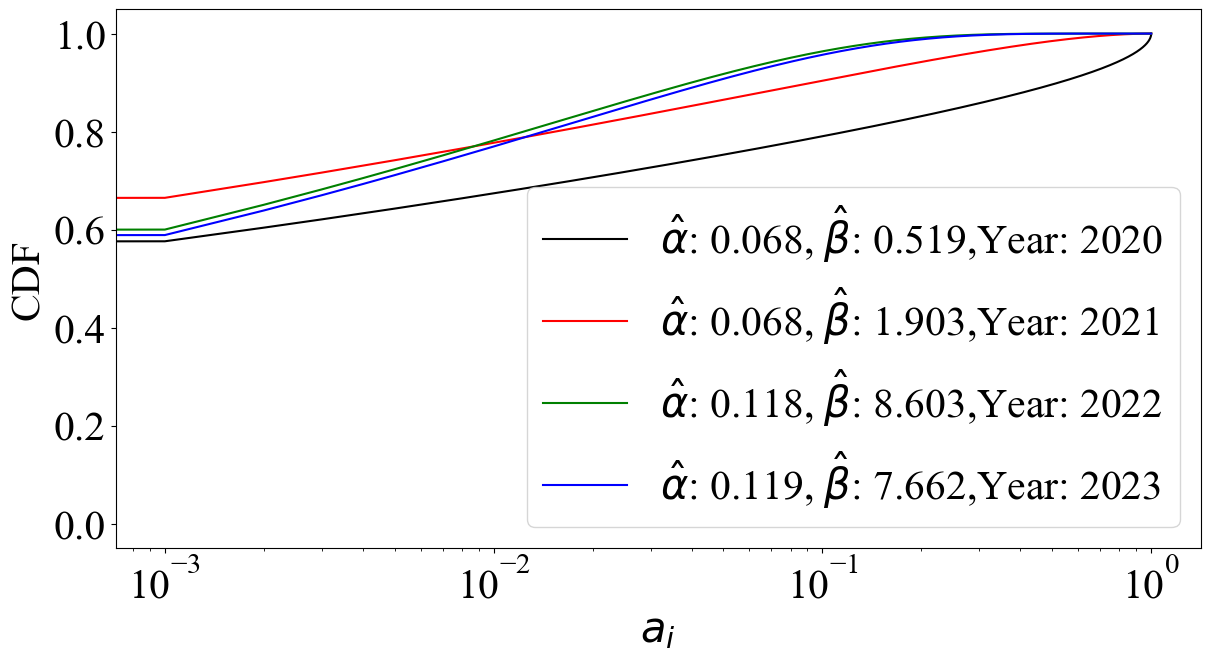

In [13]:
# Year毎のCDF
alpha_list = [0.068, 0.068, 0.118, 0.119]
beta_list = [0.519, 1.903, 8.603, 7.662]
label_list = ['Year: 2020', 'Year: 2021', 'Year: 2022', 'Year: 2023']
a = np.linspace(0, 1, 1001)
plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 30
plt.rcParams['font.family'] = 'Times New Roman'

y = stats.beta.cdf(a, alpha_list[0], beta_list[0])
plt.plot(a, y, label=fr"$\hat{{\alpha}}$: {round(alpha_list[0],3):.3f}, $\hat{{\beta}}$: {round(beta_list[0],3):.3f},{label_list[0]}", c="black")


y = stats.beta.cdf(a, alpha_list[1], beta_list[1])
plt.plot(a, y, label=fr"$\hat{{\alpha}}$: {round(alpha_list[1],3):.3f}, $\hat{{\beta}}$: {round(beta_list[1],3):.3f},{label_list[1]}", c="red")

y = stats.beta.cdf(a, alpha_list[2], beta_list[2])
plt.plot(a, y, label=fr"$\hat{{\alpha}}$: {round(alpha_list[2],3):.3f}, $\hat{{\beta}}$: {round(beta_list[2],3):.3f},{label_list[2]}", c="green")

y = stats.beta.cdf(a, alpha_list[3], beta_list[3])
plt.plot(a, y, label=fr"$\hat{{\alpha}}$: {round(alpha_list[3],3):.3f}, $\hat{{\beta}}$: {round(beta_list[3],3):.3f},{label_list[3]}", c="blue")

plt.xscale("log")

plt.xlabel(f"$a_i$", fontsize=30)
plt.ylabel("CDF", fontsize=30)

plt.tick_params(labelsize=30)
plt.legend(prop={'size': 30})
plt.savefig("../fig/cssj/cdf_all.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show()


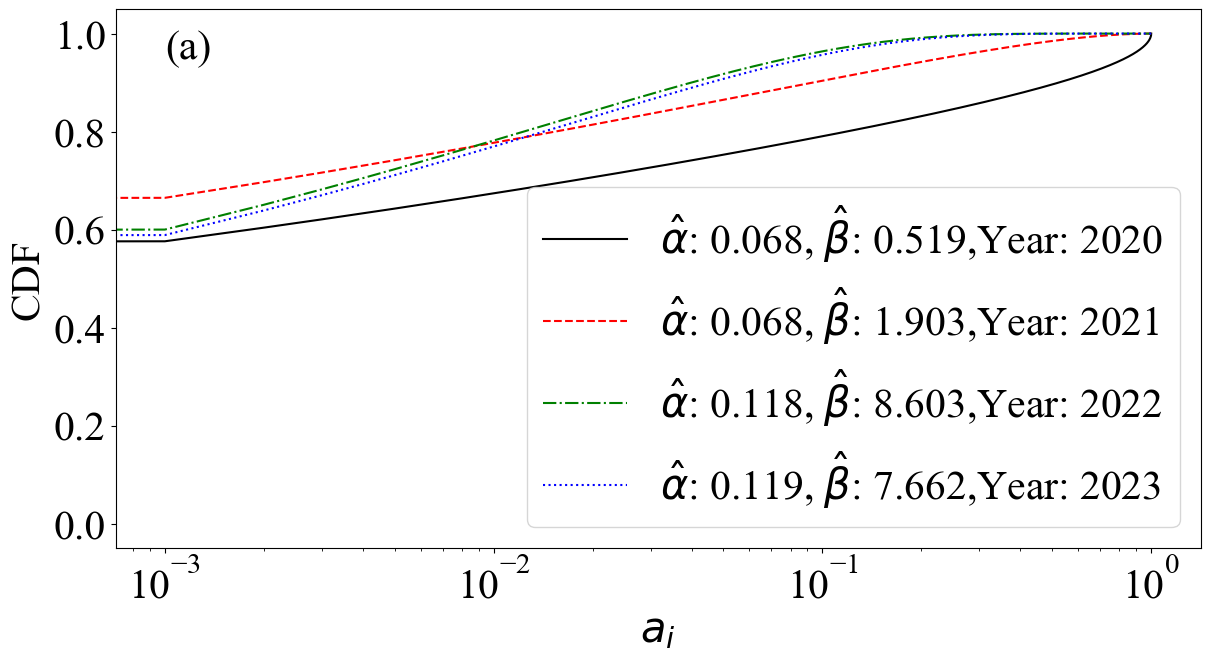

In [30]:
# スライド用
# Year毎のCDF
from matplotlib import markers


alpha_list = [0.068, 0.068, 0.118, 0.119]
beta_list = [0.519, 1.903, 8.603, 7.662]
label_list = ['Year: 2020', 'Year: 2021', 'Year: 2022', 'Year: 2023']
a = np.linspace(0, 1, 1001)
plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 30
plt.rcParams['font.family'] = 'Times New Roman'

y = stats.beta.cdf(a, alpha_list[0], beta_list[0])
plt.plot(a, y, "-", label=fr"$\hat{{\alpha}}$: {round(alpha_list[0],3):.3f}, $\hat{{\beta}}$: {round(beta_list[0],3):.3f},{label_list[0]}", c="black")


y = stats.beta.cdf(a, alpha_list[1], beta_list[1])
plt.plot(a, y, "--", label=fr"$\hat{{\alpha}}$: {round(alpha_list[1],3):.3f}, $\hat{{\beta}}$: {round(beta_list[1],3):.3f},{label_list[1]}", c="red")

y = stats.beta.cdf(a, alpha_list[2], beta_list[2])
plt.plot(a, y, "-.", label=fr"$\hat{{\alpha}}$: {round(alpha_list[2],3):.3f}, $\hat{{\beta}}$: {round(beta_list[2],3):.3f},{label_list[2]}", c="green")

y = stats.beta.cdf(a, alpha_list[3], beta_list[3])
plt.plot(a, y, ":", label=fr"$\hat{{\alpha}}$: {round(alpha_list[3],3):.3f}, $\hat{{\beta}}$: {round(beta_list[3],3):.3f},{label_list[3]}", c="blue")

plt.xscale("log")

plt.xlabel(f"$a_i$", fontsize=30)
plt.ylabel("CDF", fontsize=30)
plt.text(0.001, 0.95, r"(a)", fontsize=30, color="black")

plt.tick_params(labelsize=30)
plt.legend(prop={'size': 30})
plt.savefig("../fig/cssj/cdf_all.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show()


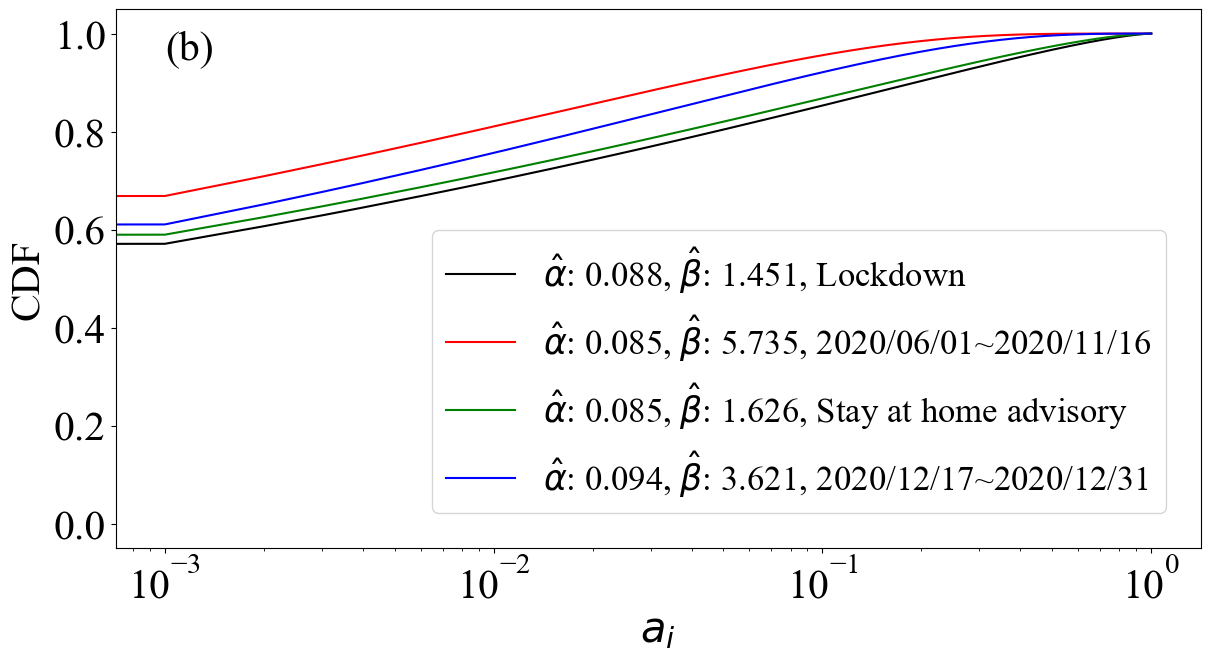

In [32]:
# 2020年のサブサンプル
a = np.linspace(0, 1, 1001)
subalpha_list = [0.088, 0.085, 0.085, 0.094]
subbeta_list = [1.451, 5.735, 1.626, 3.621]
sublabel = ['Lockdown', '2020/06/01~2020/11/16', 'Stay at home advisory', '2020/12/17~2020/12/31']
plt.figure(figsize=(14, 7))
plt.rcParams["font.size"] = 30
plt.rcParams['font.family'] = 'Times New Roman'

y = stats.beta.cdf(a, subalpha_list[0], subbeta_list[0])
plt.plot(a, y, label=fr"$\hat{{\alpha}}$: {round(subalpha_list[0],3):.3f}, $\hat{{\beta}}$: {round(subbeta_list[0],3):.3f}, {sublabel[0]}", c="black")


y = stats.beta.cdf(a, subalpha_list[1], subbeta_list[1])
plt.plot(a, y, label=fr"$\hat{{\alpha}}$: {round(subalpha_list[1],3):.3f}, $\hat{{\beta}}$: {round(subbeta_list[1],3):.3f}, {sublabel[1]}", c="red")

y = stats.beta.cdf(a, subalpha_list[2], subbeta_list[2])
plt.plot(a, y, label=fr"$\hat{{\alpha}}$: {round(subalpha_list[2],3):.3f}, $\hat{{\beta}}$: {round(subbeta_list[2],3):.3f}, {sublabel[2]}", c="green")

y = stats.beta.cdf(a, subalpha_list[3], subbeta_list[3])
plt.plot(a, y, label=fr"$\hat{{\alpha}}$: {round(subalpha_list[3],3):.3f}, $\hat{{\beta}}$: {round(subbeta_list[3],3):.3f}, {sublabel[3]}", c="blue")

plt.xlabel(f"$a_i$", fontsize=30)
plt.ylabel("CDF", fontsize=30)
plt.text(0.001, 0.95, r"(b)", fontsize=30, color="black")

plt.xscale("log")
plt.tick_params(labelsize=30)
plt.legend(prop={'size': 25},bbox_to_anchor=(1, 0), loc='lower right', borderaxespad=1)
plt.savefig(f"../fig/cssj/cdf_2020sub.pdf", bbox_inches="tight", pad_inches=0.05)
plt.show()